
# Endterm Exam — Sentiment Analysis using TensorFlow and Word2Vec

**Name:** Edwin P. Bayog Jr.  
**Section:** BSCpE 4-A  

This notebook demonstrates the creation, training, and deployment of a **Sentiment Analysis model** using TensorFlow and a **pretrained Word2Vec embedding (Google News)**.  
The project showcases preprocessing, visualization, model evaluation, and real-time web deployment through Flask and Ngrok.

📂 **GitHub Repository:** [Project-Sentiment-Analysis-Tensorflow](https://github.com/naaivvv/Project-Sentiment-Analysis-Tensorflow-)

---

### Notebook Overview

1. **Data Loading & Exploration** — Import and visualize sentiment dataset.  
2. **Preprocessing & Tokenization** — Clean text and prepare sequences for Word2Vec.  
3. **Model Training & Evaluation** — Train Keras model, plot accuracy and loss.  
4. **Visualization** — Show graphs of accuracy, loss, and learning rate.  
5. **Model Saving & Testing** — Save the `.keras` and `tokenizer.pickle` files, test predictions.  
6. **Web App Deployment (Ngrok)** — Run the Flask app with Tailwind-based chat UI for sentiment prediction.

---

> *Final submission for Endterm Exam — Sentiment Analysis Project (2025)*.


## 1 — Install & imports

Installs: `gensim` (for pretrained word2vec), `pyngrok` (tunnel), and other dependencies.

In [ ]:
# Install required packages
!pip install -q tensorflow tensorflow-datasets gensim==4.4.0 pyngrok matplotlib scikit-learn

# Imports
import os, re, pickle, json, time
import numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim import downloader as api
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
print('TensorFlow', tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 48.2 MB/s eta 0:00:00
TensorFlow 2.19.0


## 2 — Load IMDB dataset (tfds) and quick inspection

In [ ]:
ds_train, ds_test = tfds.load('imdb_reviews', split=['train', 'test'], as_supervised=True)
train_texts = []; train_labels = []
for t,l in tfds.as_numpy(ds_train):
    train_texts.append(t.decode('utf-8')); train_labels.append(int(l))
test_texts = []; test_labels = []
for t,l in tfds.as_numpy(ds_test):
    test_texts.append(t.decode('utf-8')); test_labels.append(int(l))

print('Train samples:', len(train_texts), 'Test samples:', len(test_texts))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HMTUEB_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HMTUEB_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HMTUEB_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Train samples: 25000 Test samples: 25000


## 3 — Preprocess (clean) and visualize dataset distribution

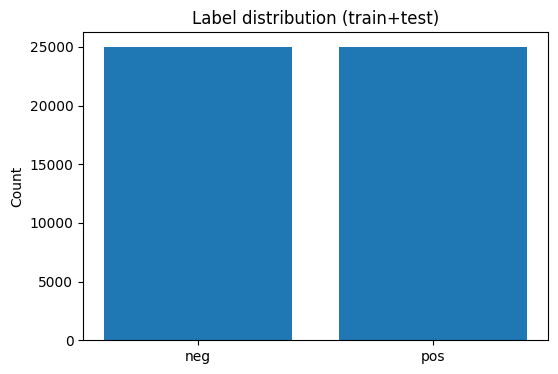

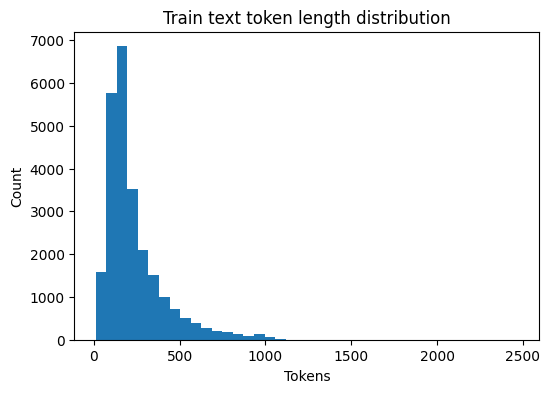

In [ ]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

train_clean = [clean_text(t) for t in train_texts]
test_clean = [clean_text(t) for t in test_texts]

# Show sample lengths distribution and label distribution
all_labels = np.array(train_labels + test_labels)
labels, counts = np.unique(all_labels, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(['neg','pos'], counts)
plt.title('Label distribution (train+test)')
plt.ylabel('Count')
plt.show()

# text length histogram (tokens)
from tensorflow.keras.preprocessing.text import text_to_word_sequence
lengths = [len(text_to_word_sequence(t)) for t in train_clean]
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=40)
plt.title('Train text token length distribution')
plt.xlabel('Tokens'); plt.ylabel('Count')
plt.show()

## 4 — Tokenize, split and prepare sequences

We use a fixed `VOCAB_SIZE` and `MAXLEN`. Tokenizer is fit on train only.

In [ ]:
VOCAB_SIZE = 30000
MAXLEN = 200
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_clean)

X = tokenizer.texts_to_sequences(train_clean)
X = pad_sequences(X, maxlen=MAXLEN, padding='post', truncating='post')
y = np.array(train_labels)

# Further split train -> train/val for training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print('Shapes:', X_train.shape, X_val.shape, y_train.shape)

Shapes: (22500, 200) (2500, 200) (22500,)


## 5 — Download pretrained Word2Vec (Google News, 300-dim)

This downloads the `word2vec-google-news-300` model via `gensim`.
**Note:** ~1.6GB download — may take several minutes.

In [ ]:
# Download via gensim-data (this may take a while)
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')  # KeyedVectors
print('Loaded pretrained vectors. Vocab size:', len(wv.key_to_index))

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded pretrained vectors. Vocab size: 3000000


## 6 — Build embedding matrix mapping tokenizer -> pretrained vectors

Words not found in pretrained vectors get small random vectors.

In [ ]:
EMBEDDING_DIM = 300
word_index = tokenizer.word_index
num_words = min(VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.random.normal(size=(num_words, EMBEDDING_DIM)).astype(np.float32) * 0.01

found = 0
for word, i in word_index.items():
    if i >= num_words: continue
    if word in wv:
        embedding_matrix[i] = wv[word]
        found += 1
print('Embedding matrix shape:', embedding_matrix.shape, 'Found pretrained vectors for', found, 'words')

Embedding matrix shape: (30000, 300) Found pretrained vectors for 24313 words


## 7 — Build model (Embedding with pretrained weights -> BiLSTM -> Dense)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(num_words=num_words, embed_dim=EMBEDDING_DIM, embedding_matrix=embedding_matrix):
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=embed_dim, weights=[embedding_matrix], input_length=MAXLEN, trainable=False, name='pretrained_embed'),
        Bidirectional(LSTM(128, return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_embed (Embedding)    │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,000,000 (34.33 MB)

## 8 — Train model (with ModelCheckpoint & EarlyStopping)

We record history to plot accuracy and loss curves later.

In [ ]:
checkpoint_path = 'sentiment_best.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=8, batch_size=128, callbacks=callbacks)

Epoch 1/8
176/176 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.7005 - loss: 0.5545 - val_accuracy: 0.8424 - val_loss: 0.3390
Epoch 2/8
176/176 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.8452 - loss: 0.3505 - val_accuracy: 0.8700 - val_loss: 0.2959
Epoch 3/8
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8781 - loss: 0.2974 - val_accuracy: 0.8812 - val_loss: 0.2768
Epoch 4/8
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8965 - loss: 0.2545 - val_accuracy: 0.8860 - val_loss: 0.2682
Epoch 5/8
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9142 - loss: 0.2215 - val_accuracy: 0.8832 - val_loss: 0.2789
Epoch 6/8
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9415 - loss: 0.1656 - val_accuracy: 0.8900 - val_loss: 0.2782
Epoch 7/8
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9634 - loss: 0.1157 - val_accuracy: 0.8824 - val_loss: 0.3127


## 9 — Plot training & validation accuracy / loss

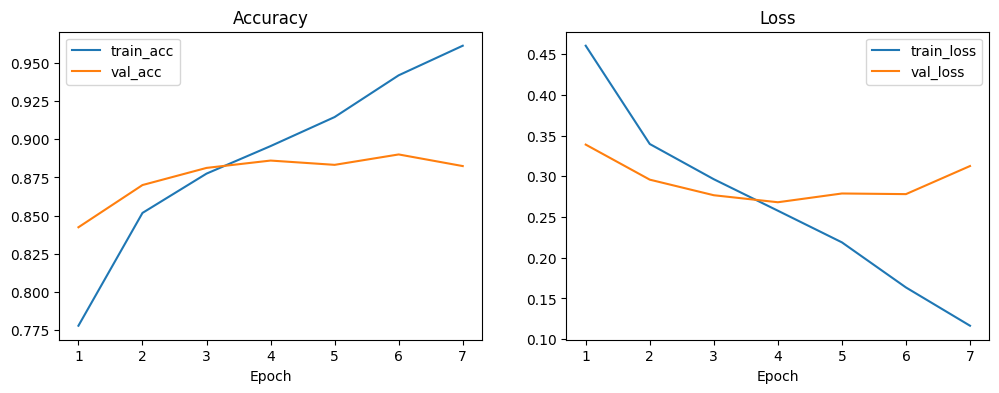

In [ ]:
# Plot accuracy and loss
hist = history.history
epochs = range(1, len(hist['loss'])+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, hist['accuracy'], label='train_acc')
plt.plot(epochs, hist['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, hist['loss'], label='train_loss')
plt.plot(epochs, hist['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.legend()
plt.show()

## 10 — Evaluate on Test Set (IMDB test split)

In [ ]:
# Prepare test sequences using tokenizer
X_test = pad_sequences(tokenizer.texts_to_sequences(test_clean), maxlen=MAXLEN, padding='post')
y_test = np.array(test_labels)

# Load best model and evaluate
best = tf.keras.models.load_model('sentiment_best.keras')
loss, acc = best.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8839 - loss: 0.2777
Test accuracy: 0.8855199813842773


## 11 — Save model (.keras) and tokenizer

In [ ]:
model_save_path = 'sentiment_w2v_model.keras'
best.save(model_save_path, include_optimizer=False)
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
print('Saved model and tokenizer:', model_save_path, 'tokenizer.pickle')

Saved model and tokenizer: sentiment_w2v_model.keras tokenizer.pickle


## 12 — Load saved model and test single predictions

In [ ]:
loaded = tf.keras.models.load_model('sentiment_w2v_model.keras')
with open('tokenizer.pickle', 'rb') as f: tk = pickle.load(f)

def predict_sentiment(text):
    t = clean_text(text)
    seq = pad_sequences(tk.texts_to_sequences([t]), maxlen=MAXLEN, padding='post')
    prob = float(loaded.predict(seq)[0][0])
    return prob

for s in ['I loved this movie', 'I hated this film', 'It was okay, not great']:
    print(s, '->', predict_sentiment(s))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
I loved this movie -> 0.973825991153717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
I hated this film -> 0.7109314799308777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
It was okay, not great -> 0.7311946749687195


## 13 — Flask app with Tailwind chat UI + pyngrok

This cell starts a Flask app and exposes it via `pyngrok`. The chat UI uses Tailwind CDN for styling. When you run this cell in Colab it will print the public ngrok URL.

In [ ]:
!pip install -q flask pyngrok tensorflow

import tensorflow as tf, pickle, re
from flask import Flask, request, jsonify, render_template_string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyngrok import ngrok

app = Flask(__name__)

# === Load model and tokenizer ===
model = tf.keras.models.load_model('sentiment_w2v_model.keras')
with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

MAXLEN = 100  # adjust if changed in training

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# === Tailwind HTML Template ===
TEMPLATE = '''
<!doctype html>
<html lang="en">
<head>
<meta charset="utf-8" />
<title>Sentiment Chatbox</title>
<script src="https://cdn.tailwindcss.com"></script>
<style>
::-webkit-scrollbar { width: 8px; }
::-webkit-scrollbar-thumb { background-color: rgba(0,0,0,0.2); border-radius: 4px; }
</style>
</head>
<body class="bg-gradient-to-br from-blue-100 to-indigo-100 min-h-screen flex flex-col justify-between items-center p-4">
  <div class="w-full max-w-2xl bg-white rounded-2xl shadow-2xl p-6 flex flex-col flex-grow">
    <h2 class="text-3xl font-semibold text-center mb-5 text-indigo-700">💬 Sentiment Chatbox</h2>
    <div id="chat" class="h-96 overflow-y-auto border border-gray-200 rounded-xl p-4 bg-gray-50 space-y-3 shadow-inner flex-grow"></div>
    <div class="flex gap-2 mt-4">
      <input id="msg" class="flex-1 border border-gray-300 rounded-lg p-3 focus:ring-2 focus:ring-indigo-400 outline-none" placeholder="Type a message..." onkeydown="if(event.key==='Enter'){send();}" />
      <button onclick="send()" class="bg-indigo-600 hover:bg-indigo-700 text-white px-5 py-2 rounded-lg font-medium shadow transition transform hover:scale-105">Send</button>
    </div>
  </div>

  <footer class="mt-6 text-center text-sm text-gray-600">
    <p>Created by <strong>Edwin P. Bayog Jr.</strong> — BSCpE 4-A | Endterm Exam 2025</p>
  </footer>

<script>
async function send(){
  const msgInput = document.getElementById('msg');
  const msg = msgInput.value.trim();
  if(!msg) return;

  const chat = document.getElementById('chat');

  // user bubble
  const userDiv = document.createElement('div');
  userDiv.innerHTML = '<div class="text-right"><span class="inline-block bg-indigo-100 text-indigo-900 px-4 py-2 rounded-xl">'+msg+'</span></div>';
  chat.appendChild(userDiv);
  chat.scrollTop = chat.scrollHeight;

  msgInput.value = '';

  // loading text
  const loader = document.createElement('div');
  loader.id = "loader";
  loader.innerHTML = '<div class="text-left text-gray-500 italic">Analyzing...</div>';
  chat.appendChild(loader);
  chat.scrollTop = chat.scrollHeight;

  // send request
  const resp = await fetch('/predict', {
    method: 'POST',
    headers: {'Content-Type': 'application/json'},
    body: JSON.stringify({text: msg})
  });
  const data = await resp.json();
  chat.removeChild(loader);

  const score = parseFloat(data.probability);
  let label = '';
  let emoji = '';
  if (score >= 0.65) { label = 'Positive'; emoji = '😄'; }
  else if (score <= 0.35) { label = 'Negative'; emoji = '😡'; }
  else { label = 'Neutral'; emoji = '😐'; }

  const botDiv = document.createElement('div');
  botDiv.innerHTML = '<div class="text-left"><span class="inline-block bg-gray-200 text-gray-900 px-4 py-2 rounded-xl">Sentiment: <strong>'+label+'</strong> '+emoji+' ('+score.toFixed(3)+')</span></div>';
  chat.appendChild(botDiv);
  chat.scrollTop = chat.scrollHeight;
}
</script>
</body>
</html>
'''

@app.route('/')
def index():
    return render_template_string(TEMPLATE)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    text = data.get('text', '')
    t = clean_text(text)
    seq = pad_sequences(tokenizer.texts_to_sequences([t]), maxlen=MAXLEN, padding='post')
    prob = float(model.predict(seq)[0][0])
    return jsonify({'probability': prob})

# === Start Flask + Ngrok ===
public_url = ngrok.connect(5000).public_url
print('🌍 Your public app is live at:', public_url)
app.run(port=5000)


🌍 Your public app is live at: https://7f73397f5df7.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [26/Oct/2025 08:28:51] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Oct/2025 08:28:52] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


INFO:werkzeug:127.0.0.1 - - [26/Oct/2025 08:29:01] "POST /predict HTTP/1.1" 200 -


In [15]:
# ✅ Download model and tokenizer files from Google Colab

from google.colab import files

# Replace these filenames with your actual saved files if needed
model_filename = "sentiment_w2v_model.keras"
tokenizer_filename = "tokenizer.pickle"

# Download model file
files.download(model_filename)

# Download tokenizer file
files.download(tokenizer_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>